# Marshall Stability

In [1]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

In [4]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModel (grid):
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best MSE:' + str(mse))

## 2. Data Import

In [5]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption [%]',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [6]:
dfMS = returnDf('MS')

## 3. Data Exploration
###  3.1 Total Sample

In [7]:
dfMS = eliminateOutliers(dfMS, 'MS of the sample (kN)')

Initial dataframe size: (406, 34)
Final dataframe size: (402, 34)


In [8]:
dfMS.iloc[:,2:].describe(include = 'all')

Modified asphalt Mix? Agreggate Type  Aggregate absorption (%)  \
count                    402            262                242.000000   
unique                     2              7                       NaN   
top                      Yes        Granite                       NaN   
freq                     319            111                       NaN   
mean                     NaN            NaN                  1.240269   
std                      NaN            NaN                  0.946592   
min                      NaN            NaN                  0.130000   
25%                      NaN            NaN                  0.470000   
50%                      NaN            NaN                  1.020000   
75%                      NaN            NaN                  2.150000   
max                      NaN            NaN                  3.040000   

        Apparent specific gravity       0.075         0.3         0.6  \
count                   84.000000  325.000000  372.000000  344.000000   
unique                        NaN         NaN         NaN         NaN   
top                           NaN         NaN         NaN         NaN   
freq                          NaN         NaN         NaN         NaN   
mean                     2.686607    6.469785   15.079839   20.374273   
std                      0.078388    5.324256    5.749322    6.530935   
min                      2.590000    2.190000    5.300000    9.000000   
25%                      2.600000    4.620000   10.660000   14.770000   
50%                      2.685000    5.280000   13.780000   20.560000   
75%                      2.725000    6.240000   17.670000   22.820000   
max                      2.800000   33.270000   35.940000   38.600000   

              2.36        4.75         9.5        12.5          19  \
count   355.000000  372.000000  344.000000  357.000000  372.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     37.026789   48.849785   68.082384   80.702129   92.721613   
std       7.607279    8.780095   10.803423   11.585460    7.199423   
min      19.770000   23.950000   47.000000   66.630000   83.110000   
25%      33.470000   41.540000   59.850000   69.380000   84.460000   
50%      35.860000   49.350000   67.840000   79.860000   94.940000   
75%      39.000000   54.770000   75.970000   90.000000  100.000000   
max      57.460000   71.500000   95.200000  100.000000  100.020000   

       Filler used Bitumen Type Penetration Grade  \
count          161                            402   
unique           5                              5   
top     Stone dust                          60/70   
freq            81                            141   
mean           NaN                            NaN   
std            NaN                            NaN   
min            NaN                            NaN   
25%            NaN                            NaN   
50%            NaN                            NaN   
75%            NaN                            NaN   
max            NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     402              377   
unique                                      3                9   
top                                     50/70               PE   
freq                                      276              150   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              NaN   
25%                                       NaN              NaN   
50%                                       NaN              NaN   
75%                                       NaN              NaN   
max                                       NaN    

I might have a problem with the $\color{red}{\text{Aggregate absorption}}$ because more than 20% of the data is missing. Regarding the $\color{red}{\text{MS}}$, there is a high dispersion ($\sigma$ = 4.56), and the Mean seems normal. According to the Australian standards, the minimum value of the Marshall stability is between two and eigth.

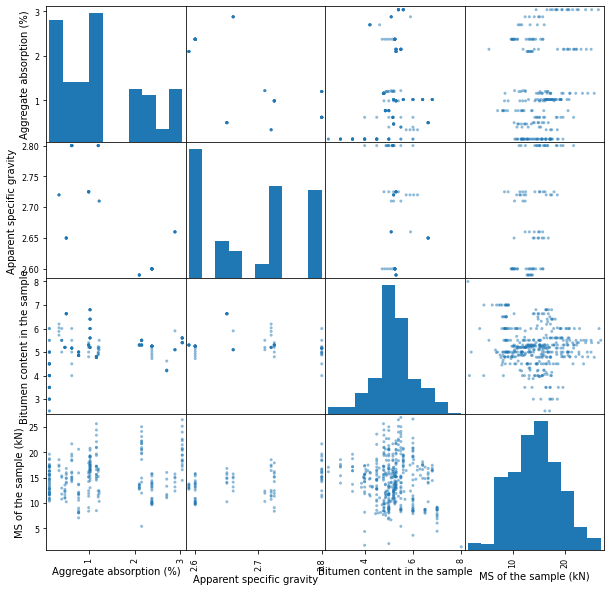

In [9]:
scatter_matrix(dfMS[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'MS of the sample (kN)']], figsize=(10, 10))
plt.show()

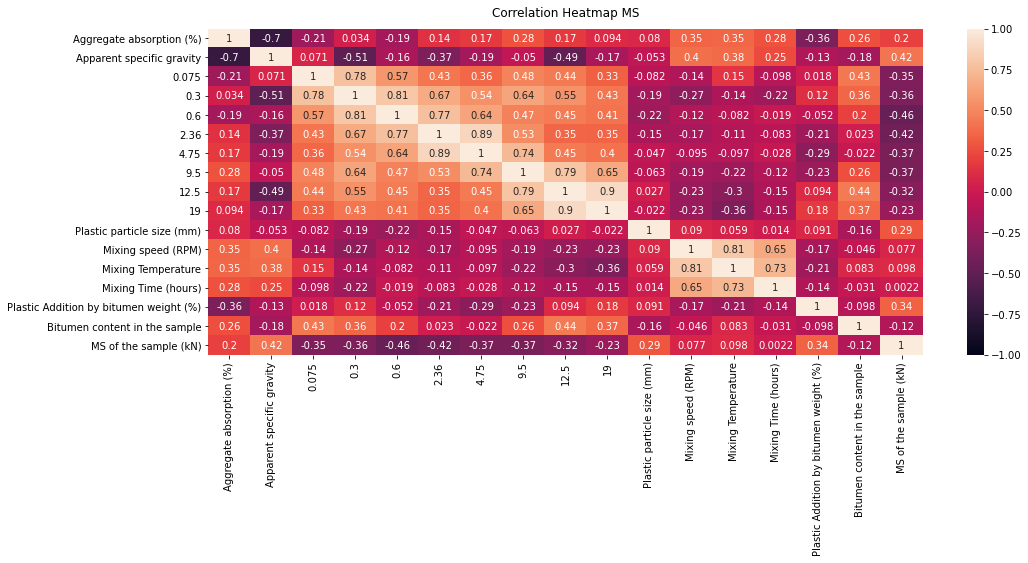

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12);

Interestingly, there is positive correlation in $\color{red}{\text{MS-Apparent specific gravity}}$ and $\color{red}{\text{MS-plastic addition by bitumen content}}$.

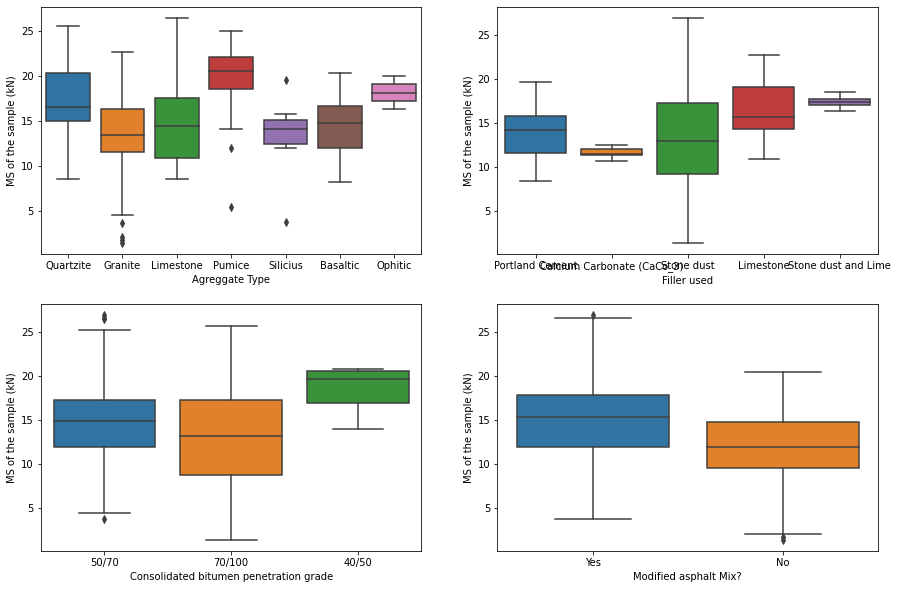

In [11]:
displayBoxPlotGraphs(dataFrame = dfMS, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

*   As it happened with the Air Voids, it exists a MS difference among the samples that employed the bitumen 40/50; however, it is important to note that the sample size for this group was not representative enough.

*   Samples with plastic modification tend to have higher MS. The glue effect of the plastic and the stiffness increase of the bitumen might serve as valid explanations.

*   No signigicant difference among the aggregate types and fillers

###  3.2 Modified mixtures

In [12]:
dfMSModvsUnmod = dfMS [['Modified asphalt Mix?', 'MS of the sample (kN)']]
dfMSModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

MS of the sample (kN)                                                  \
                  count       mean       std      min     25%       50%   
0                  83.0  11.973565  4.111246  1.36784   9.520  11.86000   
1                 319.0  15.105364  4.532964  3.73000  11.855  15.34484   

                   
        75%   max  
0  14.70446  20.4  
1  17.84500  26.9

In [13]:
dfMSModified = dfMS[dfMS['Modified asphalt Mix?'] == 'Yes']
dfMSModified.describe(include = "all")

Article ID Global ID Modified asphalt Mix? Agreggate Type  \
count         319       319                   319            215   
unique         33       319                     1              7   
top            19      1291                   Yes        Granite   
freq           61         1                   319             91   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption (%)  Apparent specific gravity       0.075  \
count                 198.000000                  66.000000  256.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    1.281566                   2.674545    6.192109   
std                     0.961319                   0.076710    4.535643   
min                     0.130000                   2.590000    2.190000   
25%                     0.477500                   2.600000    4.620000   
50%                     1.020000                   2.655000    5.280000   
75%                     2.150000                   2.725000    6.070000   
max                     3.040000                   2.800000   33.270000   

               0.3         0.6        2.36        4.75         9.5  \
count   294.000000  272.000000  281.000000  294.000000  272.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     14.967449   20.005110   36.691032   48.552211   68.098199   
std       5.425070    6.328726    7.526087    8.879260   10.716058   
min       5.300000    9.000000   19.770000   23.950000   47.000000   
25%      10.150000   14.770000   29.850000   41.540000   59.850000   
50%      14.470000   19.780000   35.750000   47.755000   67.840000   
75%      17.670000   22.055000   39.000000   54.770000   73.742500   
max      35.940000   38.600000   57.460000   71.500000   95.200000   

              12.5          19 Filler used Bitumen Type Penetration Grade  \
count   285.000000  294.000000         120                            319   
unique         NaN         NaN           5                              5   
top            NaN         NaN  Stone dust                          60/70   
freq           NaN         NaN          55                            112   
mean     80.626281   92.531054         NaN                            NaN   
std      11.670921    7.297773         NaN                            NaN   
min      66.630000   83.110000         NaN                            NaN   
25%      69.380000   84.460000         NaN                            NaN   
50%      79.860000   94.940000         NaN                            NaN   
75%      90.000000  100.000000         NaN                            NaN   
max     100.000000  100.020000         NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     319              294   
unique                                      3                8   
top                                     50/70               PE   
freq                                      218              150   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              Na

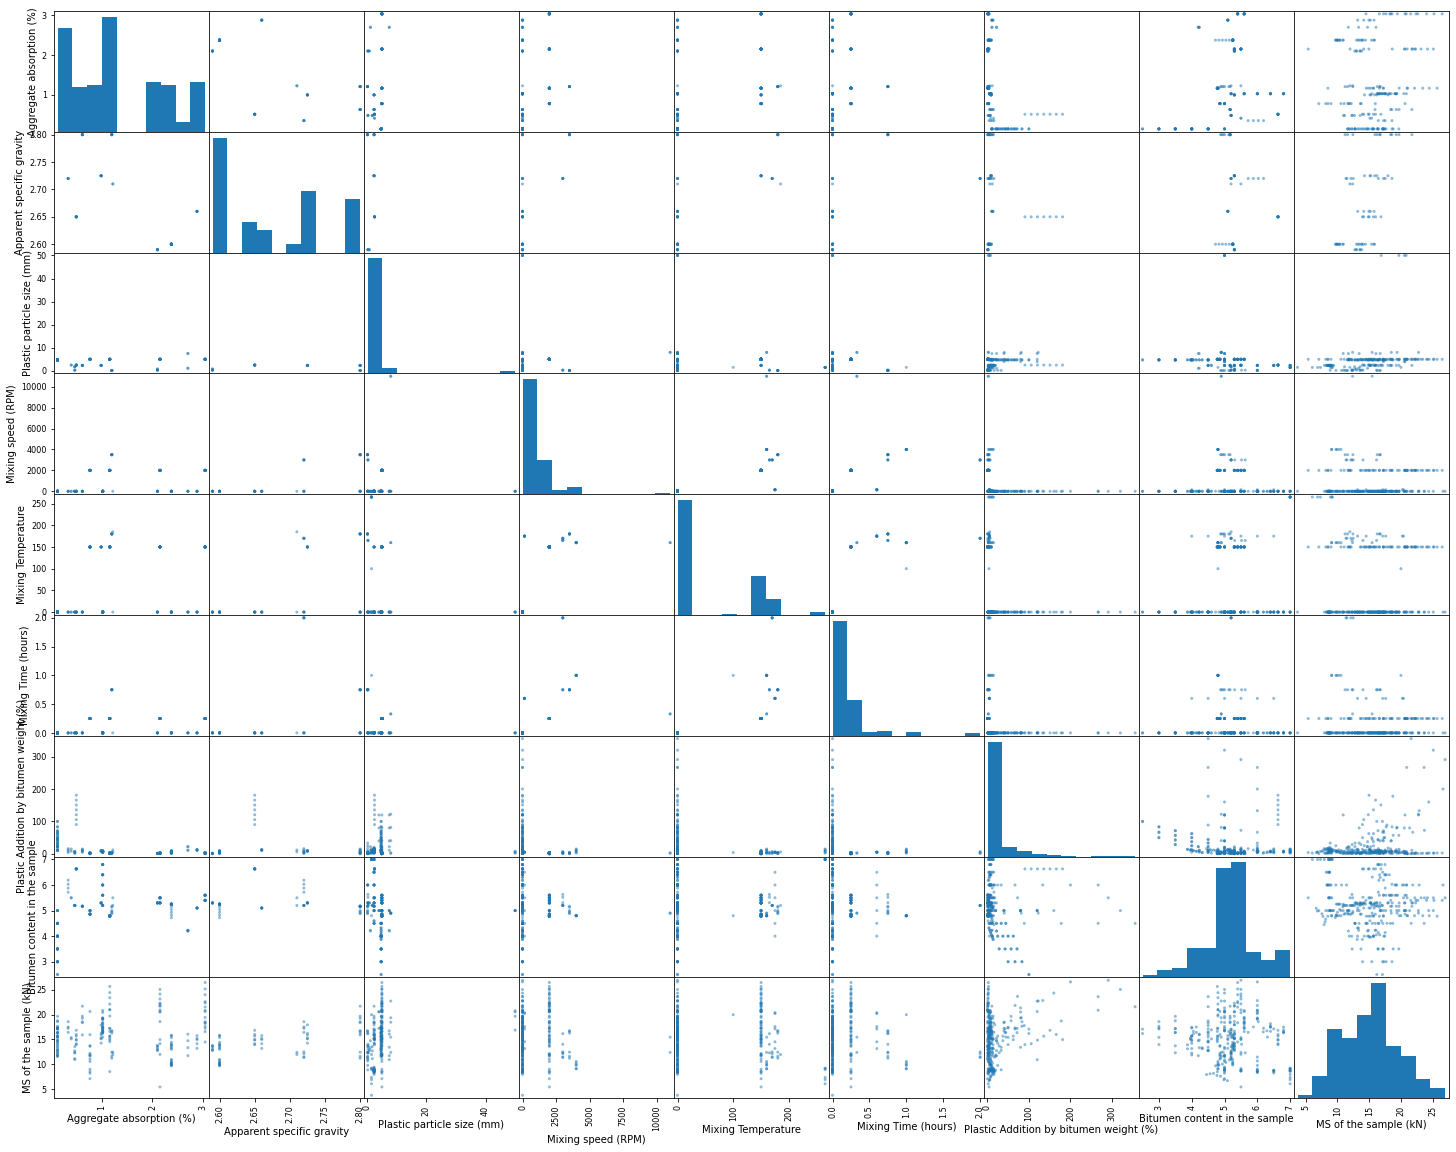

In [14]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MS of the sample (kN)']
scatter_matrix(dfMSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap MS')

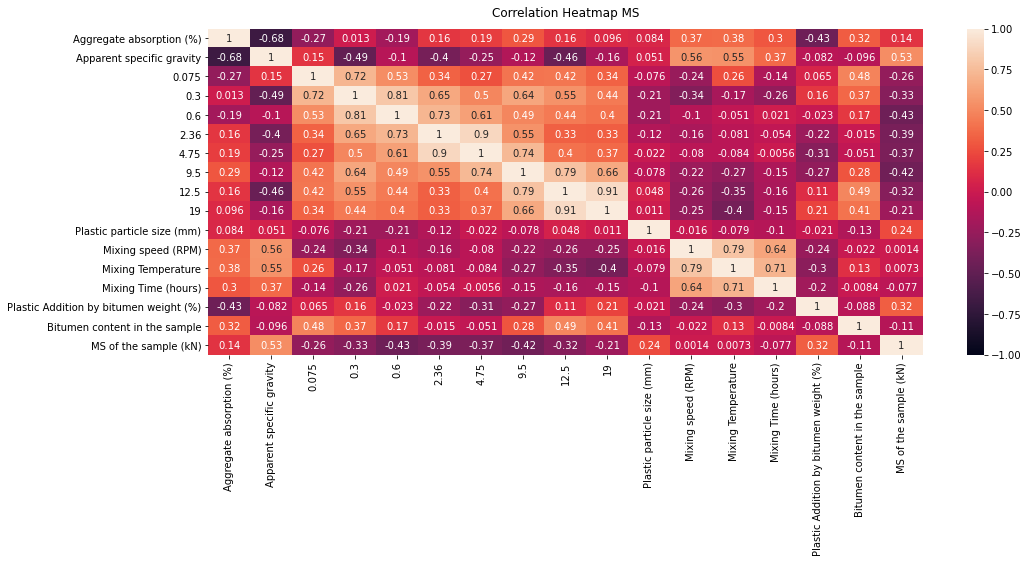

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12)

 $\color{red}{\text{MS-Apparent specific gravity}}$ presents the highest correlation with  $\color{red}{\text{MS}}$; however, it only has 66 observations, so it is not a convincing result. Other parameters such as  $\color{red}{\text{Plastic content}}$, and  $\color{red}{\text{gradation}}$ present an slight effect on the MS.

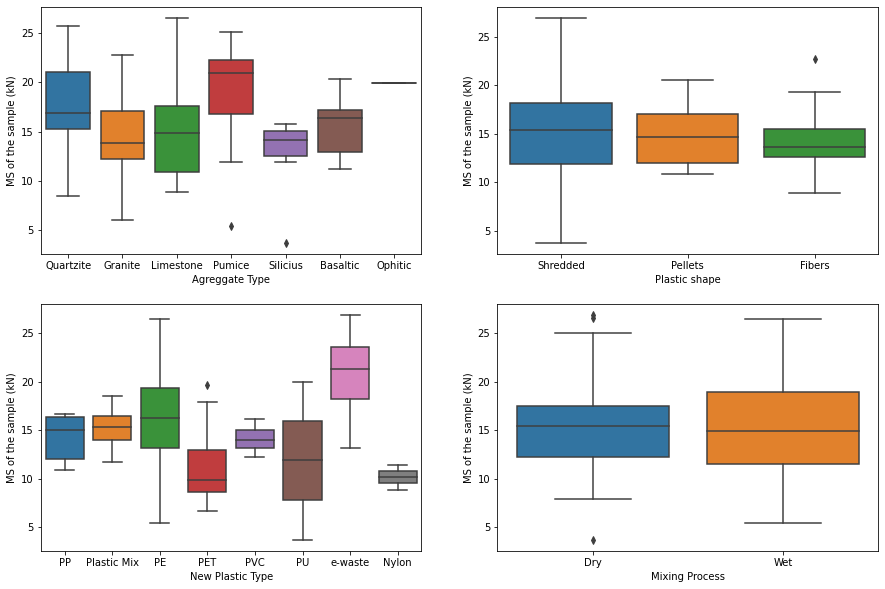

In [16]:
displayBoxPlotGraphs(dataFrame = dfMSModified, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

The mean of the **dry** and **wet** process are not significantly different.

###  3.3 Wet vs. Dry Mixing

In [17]:
dfMSWetvsDry = dfMSModified [['Mixing Process', 'MS of the sample (kN)']]
dfMSWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

MS of the sample (kN)                                                     \
                  count       mean       std      min        25%       50%   
0                 200.0  15.079810  4.142684  3.73000  12.247500  15.47000   
1                 119.0  15.148313  5.140924  5.40832  11.535825  14.93066   

                        
         75%       max  
0  17.490000  26.90000  
1  18.999925  26.44068

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


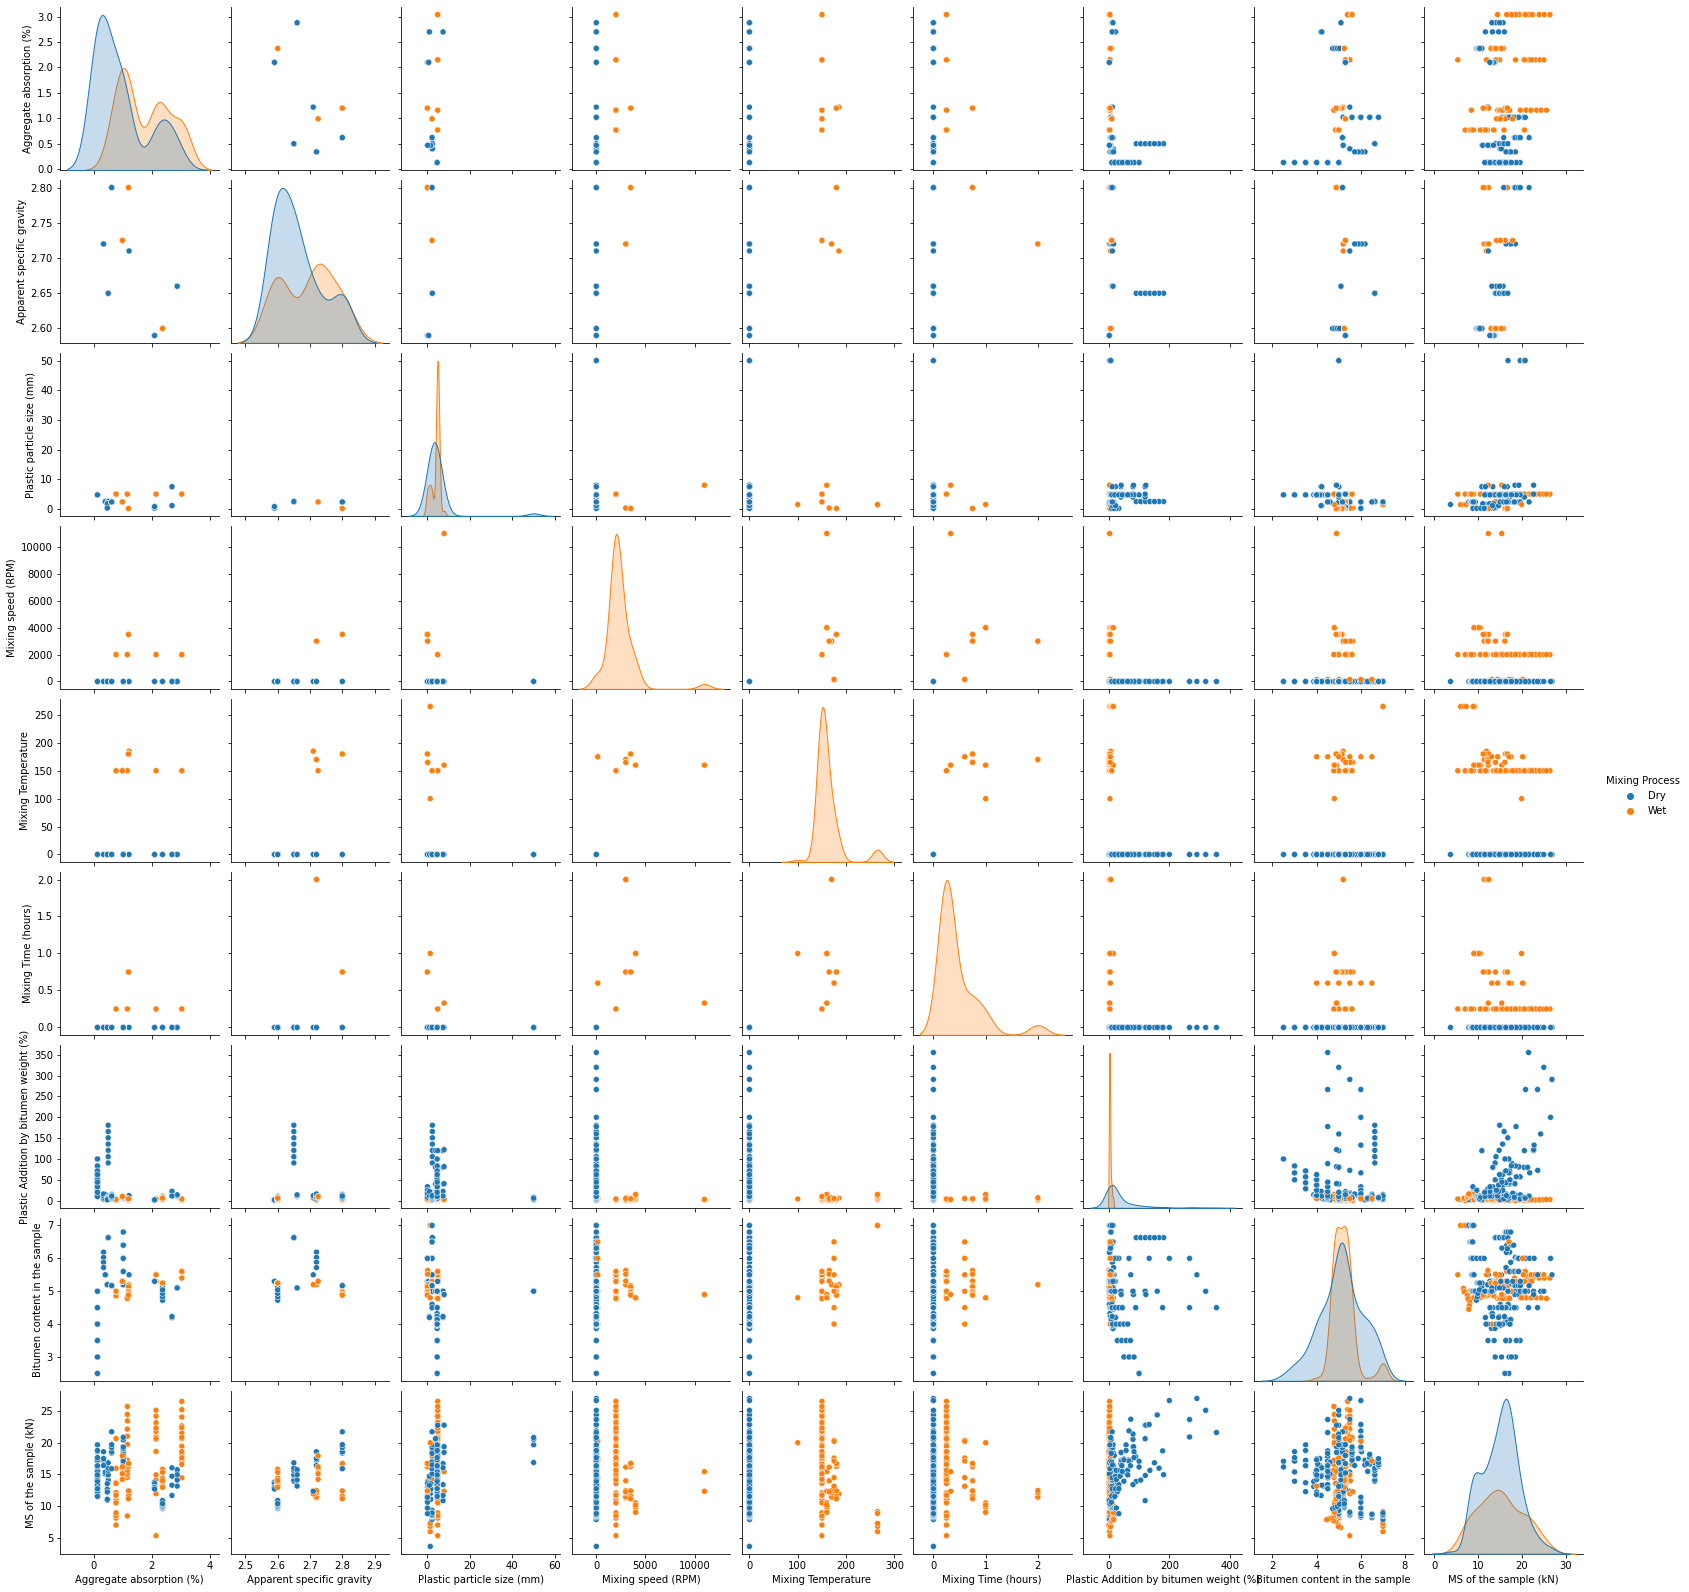

In [18]:
sns.pairplot(dfMSModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Marshall Stability summary:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Four outliers were eliminated. The final total sample included 402 data points ($\mu$ = 14.47, $\sigma$ = 4.6). 
*   $\color{red}{\text{Aggregate absorption}}$ seems to be a critical variable to include, but the percentage of missing values is more than 20%.
*   $\color{red}{\text{Apparent specific gravity}}$ presents the strongest positive correlation with the Marshall stability, but it is not a reliable inference becasue it presents many missing points (318 missing points).
* Although Marshall stability of modified asphalts is relatively higher than not modified, this is not certain because the high variances of both sample groups. $\mu_{modified}$ = 15.12 vs. $\mu_{unmodified}$ = 11.97
*   $\color{red}{\text{Percentage of plastic addition}}$ has a noticeable possitive correlation with MS. (r = 0.39) 
*   MS of dry and wet are really similar -> $\mu_{Dry}$ = 15.05 (200 observations) vs $\mu_{Wet}$ = 15.2 (119 observations)

## 4. Data Pre-processing

In [8]:
dfMS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 1 to 406
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              402 non-null    object 
 1   Global ID                               402 non-null    object 
 2   Modified asphalt Mix?                   402 non-null    object 
 3   Agreggate Type                          262 non-null    object 
 4   Aggregate absorption (%)                242 non-null    float64
 5   Apparent specific gravity               84 non-null     float64
 6   0.075                                   325 non-null    float64
 7   0.3                                     372 non-null    float64
 8   0.6                                     344 non-null    float64
 9   2.36                                    355 non-null    float64
 10  4.75                                    372 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration}}$, $\color{red}{\text{Property}}$, $\color{red}{\text{plastic size}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
3.  Eliminate rows with missing values in $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic addition by bitumen weight}}$ and $\color{red}{\text{bitumen}}$ content in sample
4.  Change categorical columns to numeric.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size(mm)}}$, and $\color{red}{\text{mixing parameters}}$.

In [8]:
#Categorical Variables
dfMSCleaned = dfMS.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade', 
                        'Property', 
                        'Units', 
                        'Plastic Size' ], axis = 1)
dfMSCleaned = dfMSCleaned.replace('N/a', 0)
dfMSCleaned = dfMSCleaned.dropna(subset=['New Plastic Type', 
                                        'Plastic Addition by bitumen weight (%)', 
                                        'Bitumen content in the sample'])
dfMSCleaned = pd.get_dummies(dfMSCleaned, columns=['New Plastic Type'], drop_first = False)
dfMSCleaned = pd.get_dummies(dfMSCleaned, drop_first = True)
dfMSCleaned = dfMSCleaned.drop(['New Plastic Type_0'], axis = 1)
dfMSCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 1 to 406
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       217 non-null    float64
 1   0.075                                          322 non-null    float64
 2   0.3                                            369 non-null    float64
 3   0.6                                            341 non-null    float64
 4   2.36                                           352 non-null    float64
 5   4.75                                           369 non-null    float64
 6   9.5                                            341 non-null    float64
 7   12.5                                           354 non-null    float64
 8   19                                             369 non-null    float64
 9   Plastic particle size (mm)                     304 non

In [9]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=123), max_iter=50)
n = imputer.fit_transform(dfMSCleaned)
dfMSCleanedImputed = pd.DataFrame(n, columns = list(dfMSCleaned.columns))
dfMSCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfMSCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       374 non-null    float64
 1   0.075                                          374 non-null    float64
 2   0.3                                            374 non-null    float64
 3   0.6                                            374 non-null    float64
 4   2.36                                           374 non-null    float64
 5   4.75                                           374 non-null    float64
 6   9.5                                            374 non-null    float64
 7   12.5                                           374 non-null    float64
 8   19                                             374 non-null    float64
 9   Plastic particle size (mm)                     374 non

In [10]:
dfMSCleanedImputed['New Plastic Type_Nylon'] = dfMSCleanedImputed['New Plastic Type_Nylon'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PE'] = dfMSCleanedImputed['New Plastic Type_PE'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PET'] = dfMSCleanedImputed['New Plastic Type_PET'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PP'] = dfMSCleanedImputed['New Plastic Type_PP'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PU'] = dfMSCleanedImputed['New Plastic Type_PU'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PVC'] = dfMSCleanedImputed['New Plastic Type_PVC'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_Plastic Mix'] = dfMSCleanedImputed['New Plastic Type_Plastic Mix'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_e-waste'] = dfMSCleanedImputed['New Plastic Type_e-waste'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed = dfMSCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [11]:
scaler = MinMaxScaler()
dfMSCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfMSCleanedImputed), columns = list(dfMSCleanedImputed.columns))
dfMSCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [12]:
X = dfMSCleanedImputedScaled.loc[:, dfMSCleanedImputedScaled.columns != 'MS of the sample (kN)']
y = dfMSCleanedImputedScaled.loc[:,'MS of the sample (kN)']
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

### 5.1 Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Lasso Linear Model

In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge Linear regression model

In [ ]:
param_grid = {'alpha': [0,5,15,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

#### Linear Elastic net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Lasso Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1, 10, 15, 30, 50, 100],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [3000]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Support vector regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid','poly'],
    'degree':[2,3],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.5, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Decision Tree regressor

In [ ]:
param_grid = {
    'max_depth':[2,3,5,10],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### XG Boost Regressor

In [14]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X, y , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

0.005803444202930476


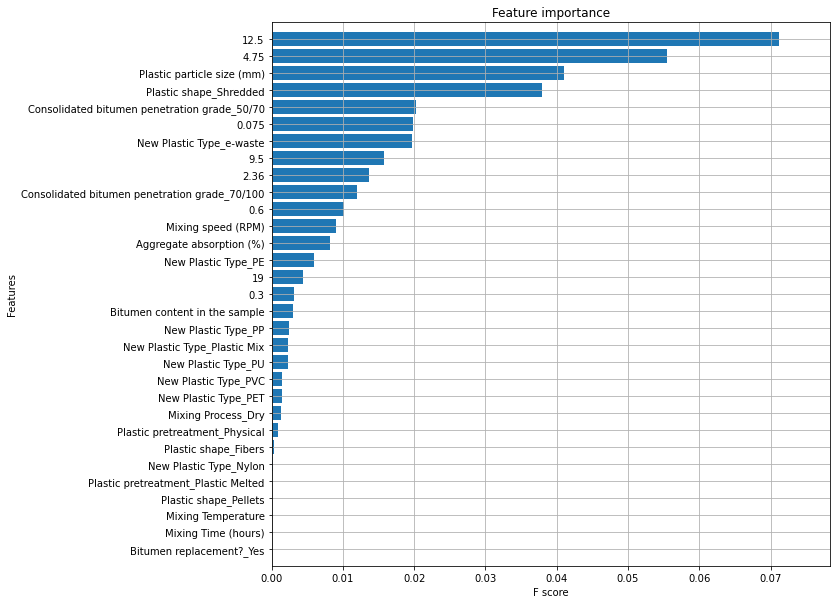

In [15]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='gain', show_values=False)
fig = ax.figure
fig.set_size_inches(10,10)

## 6. Best Model Tunning

In [16]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [17]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 1), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [22]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [23]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 'Gradation')

In [24]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19', 'Plastic particle size (mm)'], 'Gradation \n Plastic size')

In [25]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded'], 
        'Gradation \n Plastic size \n Plastic shape')

In [26]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100'], 
        'Gradation \n Plastic size \n Plastic shape \n Bitumen Type')

In [28]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP','New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Mixing speed (RPM)'], 
        'Gradation \n Plastic size \n Plastic shape \n Bitumen Type \n Plastic type \n Mixing speed')

In [29]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP','New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Mixing speed (RPM)',
        'Aggregate absorption (%)'], 
        'Gradation \n Plastic size \n Plastic shape \n Bitumen Type \n Plastic type \n Mixing speed \n Aggregate absorption')

In [30]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP','New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Mixing speed (RPM)',
        'Aggregate absorption (%)',
        'Bitumen content in the sample'], 
        'Gradation \n Plastic size \n Plastic shape \n Bitumen Type \n Plastic type \n Mixing speed \n Agg. absorption \n Bitumen content')

In [32]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP','New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Mixing speed (RPM)',
        'Aggregate absorption (%)',
        'Bitumen content in the sample',
        'Mixing Process_Dry', 'Mixing Process_Wet'], 
        'Gradation \n Plastic size \n Plastic shape \n Bitumen Type \n Plastic type \n Mixing speed \n Agg. absorption \n Bitumen content \n Mixing process')

In [33]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
        'Gradation \n Plastic size \n Plastic shape \n Bitumen Type \n Plastic type \n Mixing speed \n Agg. absorption \n Bitumen content \n Mixing process \n Rest of features')

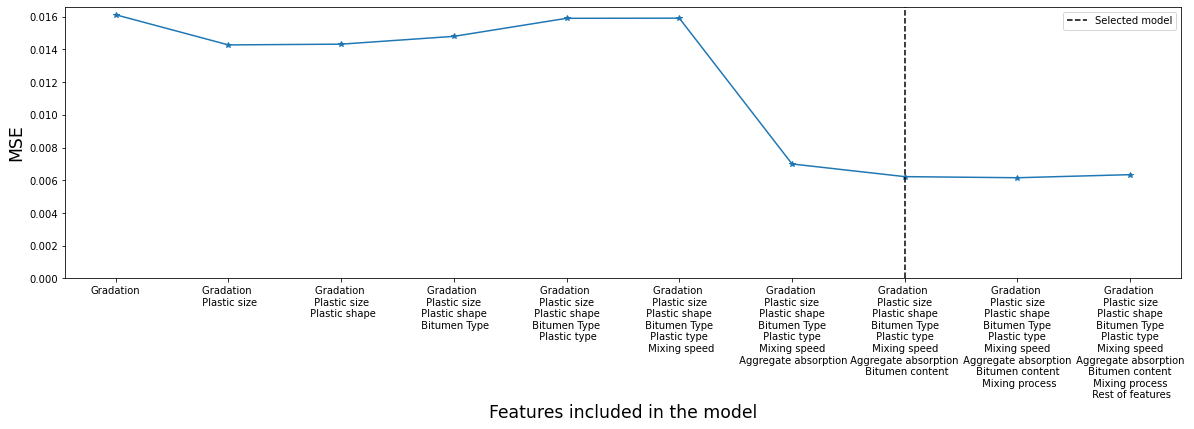

In [38]:
 plt.rcParams["figure.figsize"] = (20,5)
 plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
 plt.ylim(ymin = 0)
 plt.axvline(x='Gradation \n Plastic size \n Plastic shape \n Bitumen Type \n Plastic type \n Mixing speed \n Agg. absorption \n Bitumen content', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
 plt.ylabel('MSE', fontsize = 'xx-large')
 plt.xlabel('Features included in the model', fontsize = 'xx-large')
 plt.legend()
 plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition.
### 6.2 Model Tunning

In [30]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 1), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [18]:
X_train =  X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP','New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Mixing speed (RPM)',
        'Aggregate absorption (%)',
        'Bitumen content in the sample',
        ]]
X_test = X_test [['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Plastic particle size (mm)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP','New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Mixing speed (RPM)',
        'Aggregate absorption (%)',
        'Bitumen content in the sample',
        ]]

In [ ]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': [0],
        'gamma' : [0, 0.001, 0.01, 0.1, 1, 10]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : np.arange(0.5, 1.1, 0.1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0, 0.5 ,1],
        'colsample_bylevel':[0, 0.5 ,1],
        'colsample_bynode':[0, 0.5 ,1]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : np.arange(5,15,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [14],
        'alpha' : np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [32]:
param_grid = {
        'eta':[0.4],
        'max_depth':[6],
        'min_child_weight':[7],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [14],
        'alpha' : [0],
        'tree_method' : ['auto']
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.808636789228168
MSE test: 0.006025478629169849
Best Parameters {'alpha': 0, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.4, 'gamma': 0, 'lambda': 14, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 1, 'tree_method': 'auto'}


### 6.3 Final model evaluation on test set

In [19]:
XGModel = XGBRegressor()
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The train r2 is: ' + str(r2_train))
print('The train MSE is: ' + str(mse_train))

The test r2 is: 0.8204120449236076
The test MSE is: 0.0063366854562458
The train r2 is: 0.9976713686869721
The train MSE is: 7.497239999689813e-05


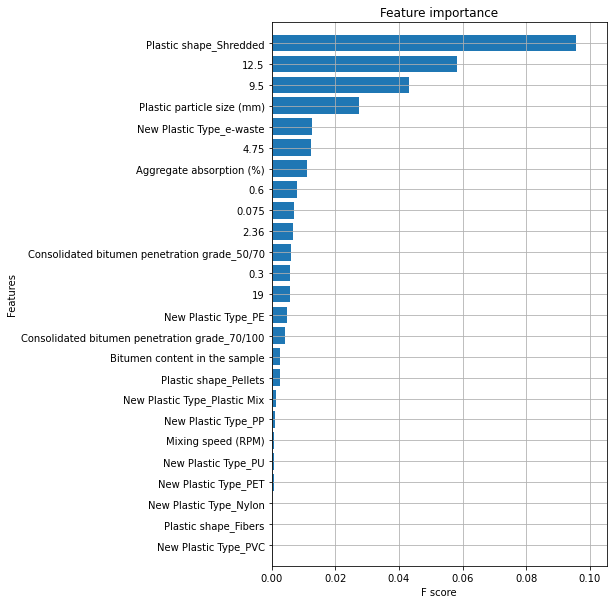

In [20]:
ax = xgb.plot_importance(XGModel, height=0.8, importance_type = 'gain', show_values = False)
fig = ax.figure
fig.set_size_inches(6,10)

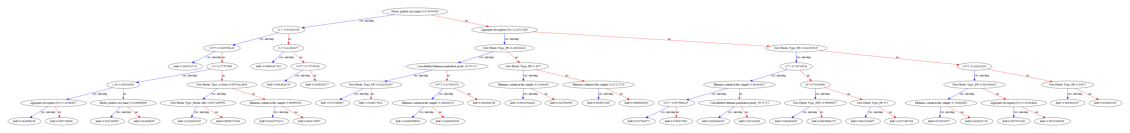

In [22]:
ax = xgb.plot_tree(XGModel)
fig = ax.figure
fig.set_size_inches(20,20)